In [118]:
import json
import re
import os
from pathlib import Path

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import tifffile
import torch
import torch.nn.functional as T
import torchvision.transforms.functional as TF
import wandb
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
from pytorch_lightning.loggers import WandbLogger

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.utils as utils

In [116]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [13]:
s0 = torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/metagene_dino_v2/results/s0_50knn.pt')
s1 = torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1_v1/codex/run_1/results/s1_20knn.pt')
s2 = torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1_v1/codex/run_1/results/s2_20knn.pt')
s3 = torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/metagene_dino_v2/results/s3_50knn.pt')
for k, v in s0.items():
    print(k, v.shape)

clustered_patches torch.Size([192, 188])
patch_centroids torch.Size([50, 1024])
patch_embs torch.Size([1024, 192, 188])


In [14]:
for s in [s0, s1, s2, s3]:
    print(s['patch_embs'].shape)

torch.Size([1024, 192, 188])
torch.Size([1024, 240, 236])
torch.Size([1024, 240, 236])
torch.Size([1024, 192, 188])


In [15]:
x1.shape[1:]

torch.Size([240, 236])

In [16]:
x0, x1, x2, x3 = s0['patch_embs'], s1['patch_embs'], s2['patch_embs'], s3['patch_embs']
x0 = TF.resize(x0, x1.shape[1:], antialias=False)
x3 = TF.resize(x3, x1.shape[1:], antialias=False)
x0.shape, x1.shape, x2.shape, x3.shape

(torch.Size([1024, 240, 236]),
 torch.Size([1024, 240, 236]),
 torch.Size([1024, 240, 236]),
 torch.Size([1024, 240, 236]))

In [23]:
slices = [x0, x1, x2, x3]

In [25]:
slices = [rearrange(x, 'c h w -> (h w) c') for x in slices]
slices[0].shape

torch.Size([56640, 1024])

In [46]:
def normalize(x):
    x -= x.mean(dim=0)
    x /= x.std(dim=0)
    return x

In [54]:
slices = [normalize(x) for x in slices]

In [92]:
class SliceTripletDataset(Dataset):
    def __init__(self, slices):
        self.slices = slices
        self.idxs = torch.arange(len(self.slices[0]))
    
    def __len__(self):
        return len(self.idxs)
    
    def __getitem__(self, idx):
        neg_patch_idx = torch.randint(0, len(self.idxs), (1,)).item()
        
        pool = np.arange(len(self.slices))
        anchor_slide_idx = np.random.choice(pool)
        pool = np.delete(pool, anchor_slide_idx)
        pos_slide_idx = np.random.choice(pool)
        neg_slide_idx = np.random.choice(pool)
        
        return {
            'anchor': self.slices[anchor_slide_idx][idx],
            'pos': self.slices[pos_slide_idx][idx],
            'neg': self.slices[neg_slide_idx][neg_patch_idx]
        }

In [ ]:
class SliceTripletDatasetV2(Dataset):
    def __init__(self, slices, kernel_size=2):
        self.slices = slices
        self.idxs = torch.arange(len(self.slices[0]))
    
    def __len__(self):
        return len(self.idxs)
    
    def __getitem__(self, idx):
        neg_patch_idx = torch.randint(0, len(self.idxs), (1,)).item()
        
        pool = np.arange(len(self.slices))
        anchor_slide_idx = np.random.choice(pool)
        pool = np.delete(pool, anchor_slide_idx)
        pos_slide_idx = np.random.choice(pool)
        neg_slide_idx = np.random.choice(pool)
        
        return {
            'anchor': self.slices[anchor_slide_idx][idx],
            'pos': self.slices[pos_slide_idx][idx],
            'neg': self.slices[neg_slide_idx][neg_patch_idx]
        }

In [93]:
ds = SliceTripletDataset(slices)

In [94]:
ds[0]

{'anchor': tensor([-0.7145, -0.5873,  1.8824,  ..., -2.1483,  0.8828,  1.9796]),
 'pos': tensor([-0.6299,  0.7921,  1.2935,  ..., -0.6145,  0.9024,  1.0062]),
 'neg': tensor([ 0.9497,  0.0120, -1.4810,  ..., -0.5854, -0.6937, -1.2840])}

In [95]:
batch_size = 256
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=10)

In [96]:
b = next(iter(dl))

In [106]:
class SliceCluster(torch.nn.Module):
    def __init__(self, in_dim, emb_dim=64):
        super().__init__()
        self.in_dim = in_dim
        self.emb_dim = emb_dim
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.in_dim, self.in_dim // 2),
            torch.nn.BatchNorm1d(self.in_dim // 2),
            torch.nn.ReLU(),
            torch.nn.Linear(self.in_dim // 2, self.in_dim // 4),
            torch.nn.BatchNorm1d(self.in_dim // 4),
            torch.nn.ReLU(),
            torch.nn.Linear(self.in_dim // 4, self.in_dim // 8),
            torch.nn.BatchNorm1d(self.in_dim // 8),
            torch.nn.ReLU(),
            torch.nn.Linear(self.in_dim // 8, self.emb_dim)
        )
        
        self.loss = torch.nn.TripletMarginLoss()
        
    def calculate_loss(self, anchor, pos, neg):
        return self.loss(anchor, pos, neg)
    
    def encode(self, x):
        return self.encoder(x)
        
    def forward(self, anchor, pos, neg):
        anchor = self.encode(anchor)
        pos = self.encode(pos)
        neg = self.encode(neg)
        
        return anchor, pos, neg

In [107]:
model = SliceCluster(len(ds[0]['anchor']))

In [108]:
anchor, pos, neg = b['anchor'], b['pos'], b['neg']
anchor, pos, neg = model(anchor, pos, neg)
anchor.shape

torch.Size([256, 64])

In [109]:
model.calculate_loss(anchor, pos, neg)

tensor(1.0040, grad_fn=<MeanBackward0>)

In [112]:
class LitSliceCluster(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        
        self.model = model
        self.lr = config['training']['lr']
        self.config = config # saving config so we can load from checkpoint
        
        self.save_hyperparameters(ignore=['model'])

    @staticmethod
    def load_from_checkpoint(checkpoint_path):
        """Need to overwrite default method due to model pickling issue"""
        checkpoint = torch.load(checkpoint_path)
        config = checkpoint['hyper_parameters']['config']
        m = SliceCluster(
            config['in_dim']
        )
        d = {re.sub(r'^model.(.*)$', r'\1', k):v for k, v in checkpoint['state_dict'].items()}
        m.load_state_dict(d)

        return LitSliceCluster(m, config)

    def training_step(self, batch, batch_idx):
        anchor, pos, neg = batch['anchor'], batch['pos'], batch['neg']
        anchor_emb, pos_emb, neg_emb = self.model(anchor, pos, neg)
        loss = self.model.calculate_loss(anchor_emb, pos_emb, neg_emb)
        losses = {f'train/loss':loss}
        self.log_dict(losses, on_step=False, on_epoch=True, prog_bar=True)
        losses['loss'] = losses['train/loss']
        
        return losses

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def forward(self, batch):
        return self.model.encode(batch)

In [129]:
project = 'slice_clusterer'
run_dir = f'/data/estorrs/mushroom/data/slice_clustering/{project}/slice_clusterer_v1'
log_dir = os.path.join(run_dir, 'logs')
chkpt_dir = os.path.join(run_dir, 'chkpts')
Path(log_dir).mkdir(parents=True, exist_ok=True)
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [204]:
logger = WandbLogger(project=project, save_dir=log_dir)

In [205]:
# wandb.finish()

In [206]:
config = {
    'in_dim': len(ds[0]['anchor']),
    'emb_dim': 64,
    'training': {
        'max_epochs': 2000,
        'limit_train_batches': 1.,
        'accelerator': 'gpu',
        'devices': [1],
        'lr': 1e-3,
        'precision': 32
    },
}
logger.experiment.config.update(config)

In [207]:
m = SliceCluster(
    config['in_dim'],
    emb_dim=config['emb_dim']
)

model = LitSliceCluster(m, config)

In [208]:
trainer = pl.Trainer(
    devices=config['training']['devices'],
    accelerator=config['training']['accelerator'],
    max_epochs=config['training']['max_epochs'],
    precision=config['training']['precision'],
    limit_train_batches=config['training']['limit_train_batches'],
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


In [ ]:
trainer.fit(model=model, train_dataloaders=dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type         | Params
---------------------------------------
0 | model | SliceCluster | 699 K 
---------------------------------------
699 K     Trainable params
0         Non-trainable params
699 K     Total params
2.796     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [178]:
trainer.save_checkpoint(os.path.join(chkpt_dir, 'ep1000.pt'))

In [180]:
best = LitSliceCluster.load_from_checkpoint(os.path.join(chkpt_dir, 'ep1000.pt'))

In [181]:
class SliceEncoderDataset(Dataset):
    def __init__(self, slices):
        self.slices = slices
        self.tups = [(i, j) for i, s in enumerate(slices) for j in range(len(s))]
    
    def __len__(self):
        return len(self.tups)
    
    def __getitem__(self, idx):
        slice_idx, patch_idx = self.tups[idx]
        
        return self.slices[slice_idx][patch_idx]

In [182]:
pred_ds = SliceEncoderDataset(slices)

In [183]:
pred_dl = DataLoader(pred_ds, batch_size=256, shuffle=False, num_workers=10)

In [184]:
predictor = pl.Trainer(
    devices=config['training']['devices'],
    accelerator=config['training']['accelerator'],
    max_epochs=config['training']['max_epochs'],
    precision=config['training']['precision'],
    limit_train_batches=config['training']['limit_train_batches'],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


In [185]:
result = predictor.predict(best, pred_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

In [186]:
embs = torch.concat(result)
embs.shape

torch.Size([226560, 64])

In [198]:
from kmeans_pytorch import kmeans
n_clusters = 50

cluster_ids_x, cluster_centers = kmeans(
    X=embs, num_clusters=n_clusters, tol=.1, distance='euclidean', device=torch.device('cuda:0')
)

running k-means on cuda:0..


[running kmeans]: 92it [01:19,  1.16it/s, center_shift=0.094672, iteration=92, tol=0.100000]  


In [199]:
slices[0].shape

torch.Size([56640, 1024])

In [200]:
slice_embs = []
idx = 0
for s in slices:
    emb = embs[idx:idx + len(s)]
    emb = rearrange(emb, '(h w) d -> d h w', h=240)
    clusters = cluster_ids_x[idx:idx + len(s)]
    reshaped = rearrange(clusters, '(ph pw) -> ph pw', ph=emb.shape[-2])
    
    
    slice_embs.append({
        'embs': emb,
        'clusters': reshaped,
    })
    
    idx += len(s)

In [201]:
slice_embs[0]['embs'].shape, slice_embs[0]['clusters'].shape

(torch.Size([64, 240, 236]), torch.Size([240, 236]))

In [191]:
import seaborn as sns
def display_labeled_as_rgb(labeled, cmap=None):
    if isinstance(labeled, torch.Tensor):
        labeled = labeled.numpy()
    cmap = sns.color_palette() if cmap is None else cmap
    labels = sorted(np.unique(labeled))
    if len(cmap) < len(labels):
        raise RuntimeError('cmap is too small')
    new = np.zeros((labeled.shape[0], labeled.shape[1], 3))
    for l, c in zip(labels, cmap):
        new[labeled==l] = c
    return new

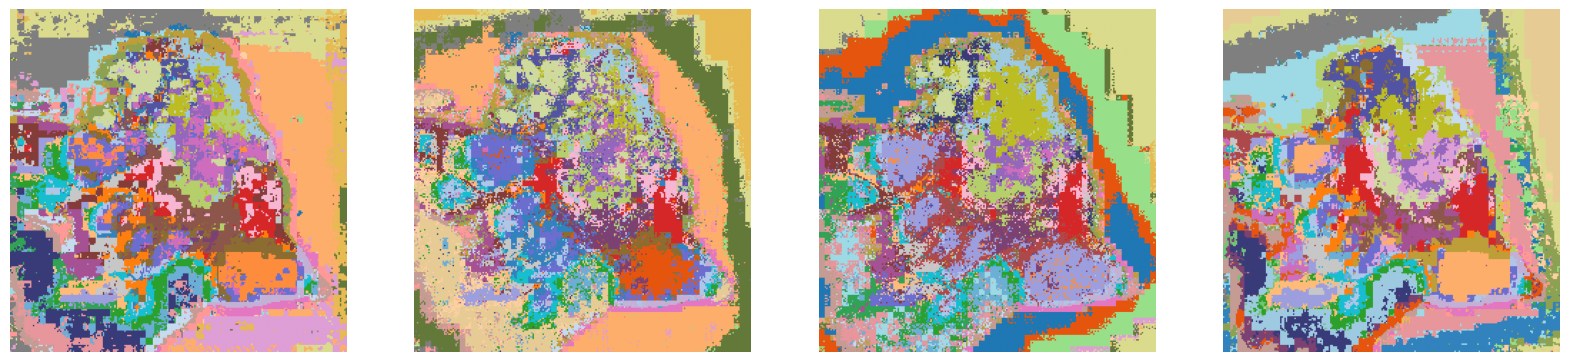

In [202]:
extended = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(slice_embs), figsize=(20, 5))
for i, d in enumerate(slice_embs):
    ax = axs[i]
    x = d['clusters']
    rgb = display_labeled_as_rgb(x, cmap=extended)
    ax.imshow(rgb)
    ax.axis('off')

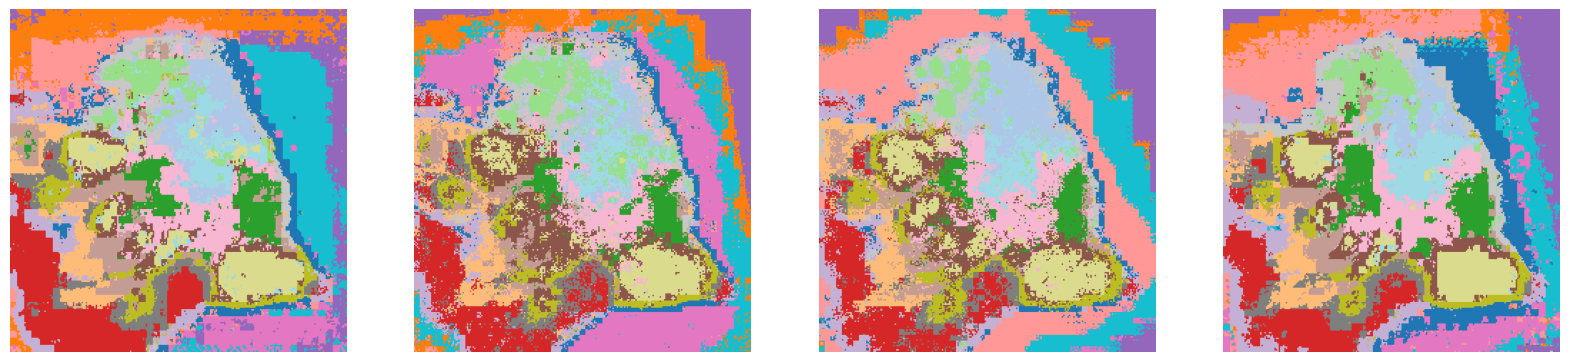

In [197]:
extended = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(slice_embs), figsize=(20, 5))
for i, d in enumerate(slice_embs):
    ax = axs[i]
    x = d['clusters']
    rgb = display_labeled_as_rgb(x, cmap=extended)
    ax.imshow(rgb)
    ax.axis('off')

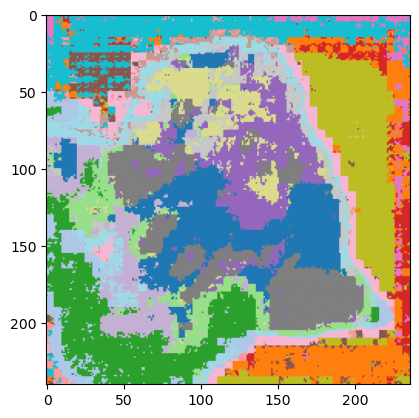

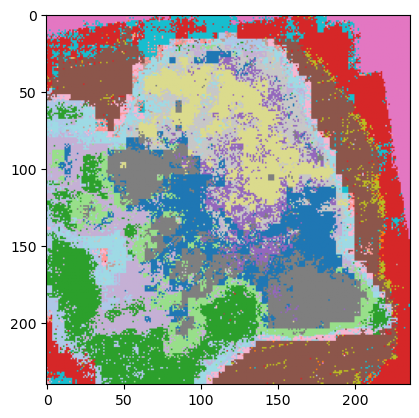

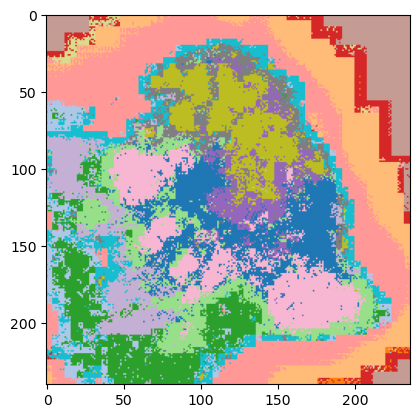

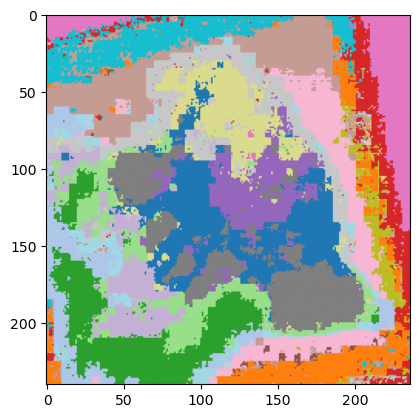

In [161]:
extended = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
for d in slice_embs:
    x = d['clusters']
    rgb = display_labeled_as_rgb(x, cmap=extended)
    plt.imshow(rgb)
    plt.show()